In [1]:
from google.colab import files
files.upload() # kaggle.json for API config

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"iobgib","key":"dfddffbf347bcf78d8d928fafa8c06a1"}'}

Note : Use the drive link for the processed dataset

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle #Create the directory
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd #Print Working Directory
!kaggle datasets download -d sorokin/faceforensics
!unzip faceforensics.zip

Streaming output truncated to the last 5000 lines.
  inflating: manipulated_sequences/Deepfakes/c23/videos/000_003.mp4  
  inflating: manipulated_sequences/Deepfakes/c23/videos/001_870.mp4  
  inflating: manipulated_sequences/Deepfakes/c23/videos/002_006.mp4  
  inflating: manipulated_sequences/Deepfakes/c23/videos/003_000.mp4  
  inflating: manipulated_sequences/Deepfakes/c23/videos/004_982.mp4  
  inflating: manipulated_sequences/Deepfakes/c23/videos/005_010.mp4  
  inflating: manipulated_sequences/Deepfakes/c23/videos/006_002.mp4  
  inflating: manipulated_sequences/Deepfakes/c23/videos/007_132.mp4  
  inflating: manipulated_sequences/Deepfakes/c23/videos/008_990.mp4  
  inflating: manipulated_sequences/Deepfakes/c23/videos/009_027.mp4  
  inflating: manipulated_sequences/Deepfakes/c23/videos/010_005.mp4  
  inflating: manipulated_sequences/Deepfakes/c23/videos/011_805.mp4  
  inflating: manipulated_sequences/Deepfakes/c23/videos/012_026.mp4  
  inflating: manipulated_sequences/Deep

In [3]:
!pip3 install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=35c31f6c8386ae80f1acfb1cf67e599ab4741ee368d9fb58749458ff7a006f28
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [4]:
#Import Relevant Libraries
import glob
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
import json
import copy
import random

In [5]:
def extract_frames(video_path):
    ret = 1
    cap = cv2.VideoCapture(video_path)
    while True:
      ret, frame = cap.read()
      if ret:
        yield frame

preprocess_parameters = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
Placeholder =  glob.glob('/content/manipulated_sequences/Deepfakes/c23/videos/*.mp4')
video_fil = Placeholder[:400]
Placeholder =  glob.glob('/content/manipulated_sequences/Face2Face/c23/videos/*.mp4')
video_fil += Placeholder[:400]
Placeholder =  glob.glob('/content/manipulated_sequences/NeuralTextures/c23/videos/*.mp4')
video_fil += Placeholder[:400]
Placeholder =  glob.glob('/content/manipulated_sequences/FaceSwap/c23/videos/*.mp4')
video_fil += Placeholder[:400]
Placeholder =  glob.glob('/content/original_sequences/youtube/c23/videos/*.mp4')
video_fil += Placeholder[:400]

In [7]:
#to load preprocessod video to memory
video_files = video_fil

random.shuffle(video_files)
random.shuffle(video_files)

frame_count = []

for video_file in video_files:
  cap = cv2.VideoCapture(video_file)
  if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<100):
    video_files.remove(video_file)
    continue
  frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print("frames are " , frame_count)
print("Total no of video: " , len(frame_count))
print('Average frame per video:',np.mean(frame_count))

frames are  [299, 446, 475, 309, 350, 311, 631, 402, 372, 307, 597, 336, 407, 564, 314, 434, 727, 568, 331, 356, 373, 300, 391, 570, 393, 475, 312, 616, 546, 415, 736, 369, 331, 531, 369, 879, 423, 359, 350, 409, 433, 514, 588, 546, 315, 331, 693, 396, 524, 495, 398, 441, 564, 294, 431, 359, 456, 330, 410, 294, 473, 320, 570, 331, 306, 323, 637, 700, 322, 1269, 329, 292, 323, 428, 413, 328, 407, 524, 527, 446, 305, 356, 590, 488, 325, 1249, 404, 424, 494, 401, 384, 447, 428, 512, 468, 390, 426, 316, 431, 416, 766, 329, 665, 764, 441, 665, 356, 425, 446, 431, 534, 399, 564, 430, 520, 337, 423, 553, 728, 329, 435, 603, 306, 521, 827, 493, 456, 476, 330, 687, 384, 460, 502, 349, 355, 586, 318, 304, 609, 440, 648, 338, 966, 414, 302, 318, 322, 460, 294, 389, 419, 515, 407, 371, 294, 303, 447, 333, 319, 380, 513, 413, 442, 634, 512, 306, 314, 525, 377, 630, 364, 713, 462, 515, 455, 302, 300, 324, 431, 323, 301, 672, 342, 423, 565, 302, 319, 613, 507, 335, 541, 383, 383, 513, 374, 451, 395, 

In [8]:
# load the video name and labels from csv and making a custom dataset
class video_dataset(Dataset):
    def __init__(self,Video_Names,labels,Seq_length = 60,transform = None):
        self.Video_Names = Video_Names
        self.labels = labels
        self.transform = transform
        self.Sequence = Seq_length

    def __len__(self):
        return len(self.Video_Names)

    def __getitem__(self,Index):
        frames = []
        video_path = self.Video_Names[Index]
        first_frame = np.random.randint(0,int(100/self.Sequence))
        temp_video = video_path.split('/')[-1]
        Label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        if(Label == 'FAKE'):
          Label = 0
        if(Label == 'REAL'):
          Label = 1
        for i,frame in enumerate(self.extract_frames(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.Sequence):
            break
        frames = torch.stack(frames)
        frames = frames[:self.Sequence]
        return frames,Label
    def extract_frames(self, video_path):
      ret = 1
      cap = cv2.VideoCapture(video_path)
      while True:
          ret, frame = cap.read()
          if ret:
            yield frame

#plot the image
def im_plot(tensor):
    Image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(Image)
    Image = cv2.merge((r,g,b))
    Image = Image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    Image = Image*255.0
    plt.imshow(Image.astype(int))
    plt.show()

In [9]:
#count the number of fake and real videos
def Video_Label(data_list):
  List_header = ["file","label"]
  Labels = pd.read_csv('https://raw.githubusercontent.com/DevanLucian15741/DeepfakeComparison_RM/main/Data_Labels/Gobal_metadata.csv',names=List_header)
  fake_count = 0 
  real_count = 0
  for data in data_list:
    temp_video = data.split('/')[-1]
    label = Labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
    if(label == 'FAKE'):
      fake_count+=1
    if(label == 'REAL'):
      real_count+=1
  return real_count,fake_count

train :  1600
test :  400
TRAIN:  Real: 323  Fake: 1277


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


TEST:  Real: 77  Fake: 323


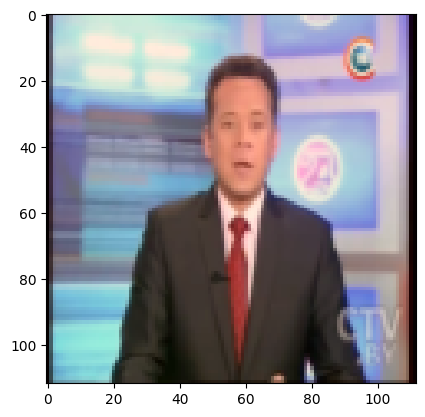

In [16]:
# load the labels and video in data loader
import pandas as pd
from sklearn.model_selection import train_test_split

header_list = ["file","label"]
labels = pd.read_csv('https://raw.githubusercontent.com/DevanLucian15741/DeepfakeComparison_RM/main/Data_Labels/Gobal_metadata.csv',names=header_list)
#print(labels)
train_videos = video_files[:int(0.8*len(video_files))]
valid_videos = video_files[int(0.8*len(video_files)):]
print("train : " , len(train_videos))
print("test : " , len(valid_videos))
print("TRAIN: ", "Real:",Video_Label(train_videos)[0]," Fake:",Video_Label(train_videos)[1])
print("TEST: ", "Real:",Video_Label(valid_videos)[0]," Fake:",Video_Label(valid_videos)[1])

Trainset_Dimensions = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((112, 112)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

Testset_Dimensions = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((112, 112)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_data = video_dataset(train_videos,labels,Seq_length = 10,transform = Trainset_Dimensions)
val_data = video_dataset(valid_videos,labels,Seq_length = 10,transform = Trainset_Dimensions)
train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,num_workers = 4)
valid_loader = DataLoader(val_data,batch_size = 4,shuffle = True,num_workers = 4)
image,label = train_data[0]
im_plot(image[0,:,:,:])

In [27]:
#Model with feature visualization
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 960, lstm_layers=1 , hidden_dim = 960, bidirectional = False):
        super(Model, self).__init__()
        model = models.mobilenet_v3_large(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(960,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,960)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [28]:
model = Model(2).cuda()
a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
#Delete the model if you are running this after the first time
# del model

In [30]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
def train_epoch(epoch, epochs_count, Load_Data, model, criterion, optimizer):
    model.train()
    AVARAGE_LOSSES = AverageMeter()
    AVARAGE_ACCURACY = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(Load_Data):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        Loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        Accuracy = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        AVARAGE_LOSSES.update(Loss.item(), inputs.size(0))
        AVARAGE_ACCURACY.update(Accuracy, inputs.size(0))
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    epochs_count,
                    i,
                    len(Load_Data),
                    AVARAGE_LOSSES.avg,
                    AVARAGE_ACCURACY.avg))
    torch.save(model.state_dict(),'/content/checkpoint.pt')
    return AVARAGE_LOSSES.avg,AVARAGE_ACCURACY.avg


In [31]:
def test(epoch,model, Load_Data ,criterion):
    print('Testing')
    model.eval()
    AVARAGE_LOSSES = AverageMeter()
    AVARAGE_ACCURACY = AverageMeter()
    Prediction = []
    Actual_Value = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(Load_Data):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            Losses = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            Accuracy = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1) 
            Actual_Value += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            Prediction += p.detach().cpu().numpy().reshape(len(p)).tolist()
            AVARAGE_LOSSES.update(Losses.item(), inputs.size(0))
            AVARAGE_ACCURACY.update(Accuracy, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(Load_Data),
                        AVARAGE_LOSSES.avg,
                        AVARAGE_ACCURACY.avg
                        )
                    )
        print('\nAccuracy {}'.format(AVARAGE_ACCURACY.avg))
    return Actual_Value,Prediction,AVARAGE_LOSSES.avg,AVARAGE_ACCURACY.avg

In [32]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [33]:
import seaborn as sn
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    Confusion_Matrix = confusion_matrix(y_true, y_pred)
    print('True Positive = ', Confusion_Matrix[0][0])
    print('False Positive = ', Confusion_Matrix[0][1])
    print('False Negative = ', Confusion_Matrix[1][0])
    print('True Negative = ', Confusion_Matrix[1][1])
    print('\n')
    df_cm = pd.DataFrame(Confusion_Matrix, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (Confusion_Matrix[0][0]+Confusion_Matrix[1][1])/(Confusion_Matrix[0][0]+Confusion_Matrix[0][1]+Confusion_Matrix[1][0]+ Confusion_Matrix[1][1])
    print("Accuracy = ",calculated_acc*100)

In [34]:
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  Loss_Training = train_loss_avg
  Loss_Value = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, Loss_Training, 'g', label='Training loss')
  plt.plot(epochs, Loss_Value, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  Loss_Training = train_accuracy
  Loss_Value = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, Loss_Training, 'g', label='Training accuracy')
  plt.plot(epochs, Loss_Value, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

[Epoch 1/20] [Batch 399 / 400] [Loss: 0.571484, Acc: 79.00%]Testing
[Batch 99 / 100]  [Loss: 0.507674, Acc: 80.75%]
Accuracy 80.75
[Epoch 2/20] [Batch 399 / 400] [Loss: 0.553069, Acc: 79.81%]Testing
[Batch 99 / 100]  [Loss: 0.516423, Acc: 80.75%]
Accuracy 80.75
[Epoch 3/20] [Batch 399 / 400] [Loss: 0.543031, Acc: 79.81%]Testing
[Batch 99 / 100]  [Loss: 0.506825, Acc: 80.75%]
Accuracy 80.75
[Epoch 4/20] [Batch 399 / 400] [Loss: 0.543898, Acc: 79.81%]Testing
[Batch 99 / 100]  [Loss: 0.521571, Acc: 80.75%]
Accuracy 80.75
[Epoch 5/20] [Batch 399 / 400] [Loss: 0.544904, Acc: 79.81%]Testing
[Batch 99 / 100]  [Loss: 0.534512, Acc: 80.50%]
Accuracy 80.5
[Epoch 6/20] [Batch 399 / 400] [Loss: 0.529785, Acc: 79.81%]Testing
[Batch 99 / 100]  [Loss: 0.516858, Acc: 80.50%]
Accuracy 80.5
[Epoch 7/20] [Batch 399 / 400] [Loss: 0.517964, Acc: 79.62%]Testing
[Batch 99 / 100]  [Loss: 0.530017, Acc: 80.00%]
Accuracy 80.0
[Epoch 8/20] [Batch 399 / 400] [Loss: 0.506271, Acc: 80.00%]Testing
[Batch 99 / 100]  

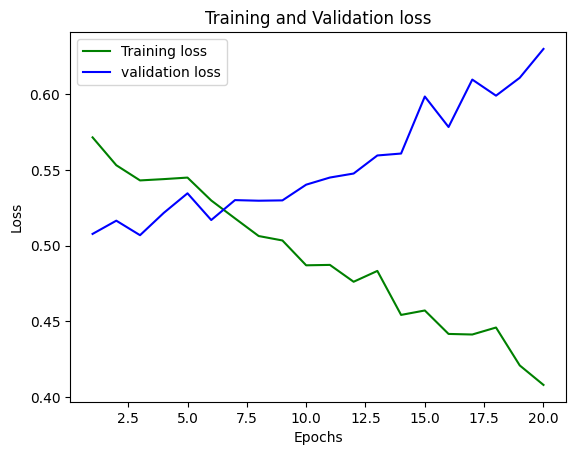

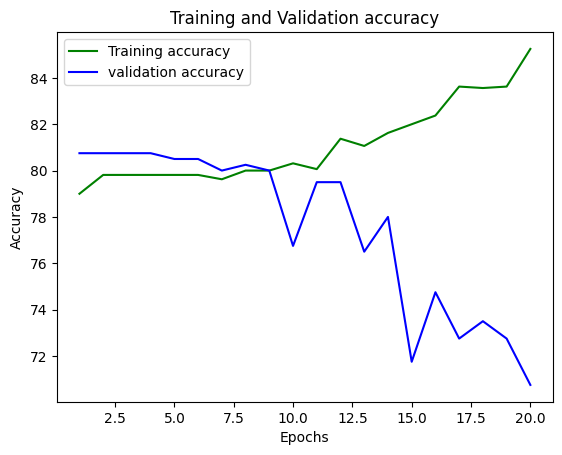

[[259  64]
 [ 53  24]]
True Positive =  259
False Positive =  64
False Negative =  53
True Negative =  24




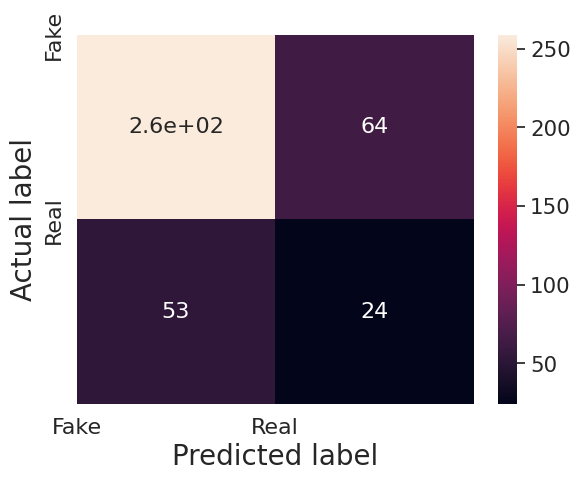

Accuracy =  70.75


In [35]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs 
num_epochs = 20
#Optimizer
Opt = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)
#Crit
Crit = nn.CrossEntropyLoss().cuda()
LossAvarage_Traning =[]
LossAvarage_Testing = []
Accuracy_Traning = []
Accuracy_Testing = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,Crit,Opt)
    LossAvarage_Traning.append(l)
    Accuracy_Traning.append(acc)
    Correct,Predicted,t_Loss,t_accuracy = test(epoch,model,valid_loader,Crit)
    LossAvarage_Testing.append(t_Loss)
    Accuracy_Testing.append(t_accuracy)
plot_loss(LossAvarage_Traning,LossAvarage_Testing,len(LossAvarage_Traning))
plot_accuracy(Accuracy_Traning,Accuracy_Testing,len(Accuracy_Traning))
print(confusion_matrix(Correct,Predicted))
print_confusion_matrix(Correct,Predicted)

In [36]:
torch.save(model, 'model_pytorch.pt')

In [37]:
#Making Predictions

im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
sm = nn.Softmax()
inv_normalize =  transforms.Normalize(mean=-1*np.divide(mean,std),std=np.divide([1,1,1],std))
def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)
    cv2.imwrite('./2.png',image*255)
    return image

def predict(model,img,path = './'):
  fmap,logits = model(img.to('cuda'))
  params = list(model.parameters())
  weight_softmax = model.linear1.weight.detach().cpu().numpy()
  logits = sm(logits)
  _,prediction = torch.max(logits,1)
  confidence = logits[:,int(prediction.item())].item()*100

  idx = np.argmax(logits.detach().cpu().numpy())
  bz, nc, h, w = fmap.shape
  out = np.dot(fmap[-1].detach().cpu().numpy().reshape((nc, h*w)).T,weight_softmax[idx,:].T)
  predict = out.reshape(h,w)
  predict = predict - np.min(predict)
  predict_img = predict / np.max(predict)
  predict_img = np.uint8(255*predict_img)
  out = cv2.resize(predict_img, (im_size,im_size))
  heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
  img = im_convert(img[:,-1,:,:,:])
  result = heatmap * 0.5 + img*0.8*255
  cv2.imwrite('/content/1.png',result)
  result1 = heatmap * 0.5/255 + img*0.8
  r,g,b = cv2.split(result1)
  result1 = cv2.merge((r,g,b))

  return [int(prediction.item()),confidence]

class validation_dataset(Dataset):
    def __init__(self,video_names,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a) 
        for i,frame in enumerate(self.extract_frames(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)
    def extract_frames(self, path):
      ret = 1
      cap = cv2.VideoCapture(path)
      while True:
          ret, frame = cap.read()
          if ret:
            yield frame

temp =  glob.glob('/content/manipulated_sequences/Deepfakes/c23/videos/*.mp4')
x_test = temp[100:200]
temp =  glob.glob('/content/manipulated_sequences/Face2Face/c23/videos/*.mp4')
x_test += temp[300:400]
temp =  glob.glob('/content/manipulated_sequences/NeuralTextures/c23/videos/*.mp4')
x_test += temp[80:200]
temp =  glob.glob('/content/manipulated_sequences/FaceSwap/c23/videos/*.mp4')
x_test += temp[90:220]
temp =  glob.glob('/content/original_sequences/youtube/c23/videos/*.mp4')
x_test += temp[300:450]

def retrieving_truth(videos):
  header_list = ["file","label"]
  lab = pd.read_csv('https://raw.githubusercontent.com/DevanLucian15741/DeepfakeComparison_RM/main/Data_Labels/Gobal_metadata.csv',names=header_list)
  temp_video = videos.split('/')[-1]
  label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
  if(label == 'FAKE'):
    return 0
  elif (label == 'REAL') :
    return 1
  else :
    return -1

header_list = ["file","label"]
lab = pd.read_csv('https://raw.githubusercontent.com/DevanLucian15741/DeepfakeComparison_RM/main/Data_Labels/Gobal_metadata.csv',names=header_list)

model = Model(2).cuda()
path_to_model = '/content/model_pytorch.pt'
t = 0


path_to_videos= x_test

video_dataset = validation_dataset(path_to_videos,sequence_length = 20,transform = Trainset_Dimensions)
for i in range(0,len(path_to_videos)):
  prediction = predict(model,video_dataset[i],'./')
  if prediction[0] == retrieving_truth(path_to_videos[i]) :
    t = t+1

print('Testing Accuracy: {:.2f}%'.format(t/len(x_test)*100))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-37-860ab77d86c6>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = sm(logits)
<ipython-input-37-860ab77d86c6>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = sm(logits)

Testing Accuracy: 61.33%


<ipython-input-37-860ab77d86c6>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = sm(logits)
